In [1]:
%matplotlib inline
#can do "%matplotlib notebook" for interactive plots
import autograd.numpy as np  # Thinly-wrapped numpy
from autograd import grad
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import math
from mpl_toolkits.mplot3d import Axes3D

pi = math.pi

In [2]:
# Flag to set nonconvex-nonconvex objective or convex-concave objective
nonconvex = True

#Flag to set strength of bilinear term
gda_converge = True

s1 = "non" if nonconvex else ""
s2 = "-converge" if gda_converge else ""
save_suffix = "-{}convex{}.png".format(s1, s2)
plt.rcParams.update({'font.size': 18})

In [3]:
init_point = [5,5]

nonconvex_minmax = [0,0]
convex_minmax = [ 0.15176576, -0.17928959] if gda_converge else [0.04871984, -0.05121776] 

minmax = nonconvex_minmax if nonconvex else convex_minmax
fig_size = (12,10)

In [4]:
# Defining objective functions
def nonconvex_f(x):
    if x < -pi/2:
        return -3*(x+pi/2)
    elif x <= pi/2:
        return -3*np.cos(x)
    else:
        return -np.cos(x) + 2*x - pi    

def logexp(x):
    return np.log(1.0+np.exp(x))

def f(x):
    if nonconvex:
        return nonconvex_f(x)
    else:
        return logexp(x)
    
def split_z(z):
    L = z.size//2
    x = z[:L]
    y = z[L:]
    return x, y

def g(z):
    x, y = split_z(z)
    c = 3 if gda_converge else 10
    return c*x @ y  + f(x) - f(y)

/Users/kevinlai/anaconda3/lib/python3.6/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


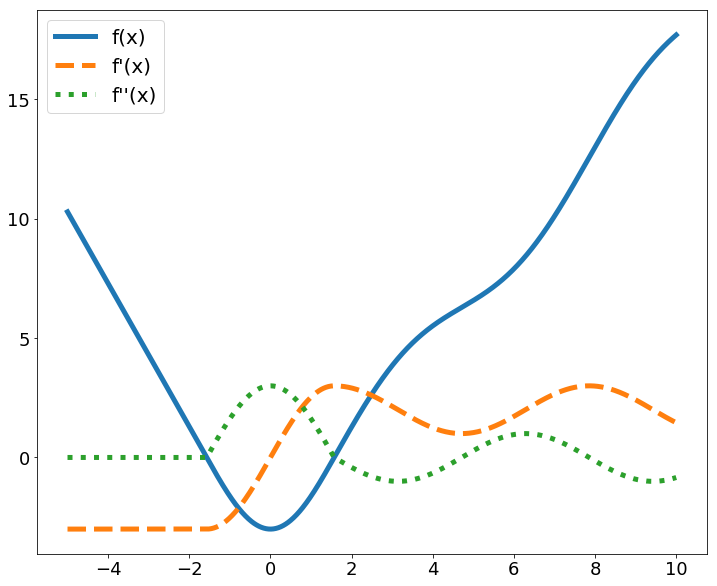

In [5]:
# Plot nonconvex function

gf = grad(f)
hf = grad(gf)
x = np.linspace(-5, 10, 1000)
figure(figsize=(12, 10))
plt.plot(x,[f(z) for z in x], linewidth=5)
plt.plot(x, [gf(z) for z in x], linestyle='--', linewidth=5)
plt.plot(x, [hf(z) for z in x], linestyle=':', linewidth=5)
plt.legend(["f(x)", "f'(x)", "f''(x)"], prop={'size': 20})

In [6]:
def xi(z, g):
    L = z.size//2
    x = z[:L]
    y = z[L:]
    g_x = lambda a: g(np.concatenate([a,y]))
    g_y = lambda a: -1*g(np.concatenate([x,a]))
    return np.concatenate([grad(g_x)(x), grad(g_y)(y)])

def xi_g(z):
    return xi(z, g)

def H(z, g):
    v = xi(z, g)
    return 0.5*np.sum([v[i]**2  for i in range(v.shape[0])])

def H_g(z):
    return H(z, g)

In [7]:
# Simultaneous gradient descent-ascent
def gda(z, eta):
    return z - eta*xi_g(z)

# Hamiltonian Gradient Descent
def hgd(z, eta):
    return z - eta*grad(H_g)(z)

# Consensus Optimization
def co(z, eta, gamma):
    return z - eta*xi_g(z) - eta*gamma*grad(H_g)(z)


In [8]:
# Set contour limits for HGD-GDA
lim = 10 if nonconvex else 15 
xlist = np.linspace(-lim, lim, 100)
ylist = np.linspace(-lim, lim, 100)

X, Y = np.meshgrid(xlist, ylist)
Z = np.zeros(X.shape)

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i,j] = g(np.array([X[i,j], Y[i,j]]))

In [9]:
T = 300 if gda_converge else 150
eta = .01
gda_iters = np.zeros((T+1,2))
gda_iters[0,:] = init_point

hgd_iters = np.zeros((T+1,2))
hgd_iters[0,:] = init_point

for t in range(T):
    gda_iters[t+1,:] = gda(gda_iters[t,:], eta)
    hgd_iters[t+1,:] = hgd(hgd_iters[t,:], eta)
    

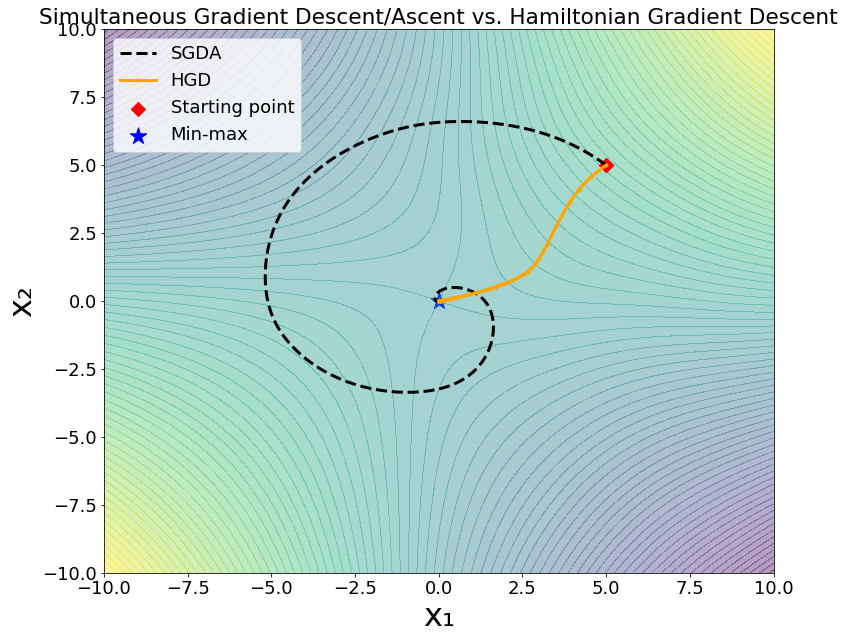

In [10]:
figure(figsize=fig_size)

plt.plot(gda_iters[:,0], gda_iters[:,1], '--', c='k', linewidth=3)
plt.plot(hgd_iters[:,0], hgd_iters[:,1], '.-', c='orange', linewidth=3)
plt.scatter(init_point[0], init_point[1], s=100, marker='D', c='r')
plt.scatter(minmax[0], minmax[1], s=300, marker='*', c='b')

plt.contourf(X, Y, Z, 100, alpha=0.4)
plt.scatter(init_point[0], init_point[1], s=100, marker='D', c='r')

plt.legend(["SGDA", "HGD", "Starting point", "Min-max"])
plt.title("Simultaneous Gradient Descent/Ascent vs. Hamiltonian Gradient Descent")
plt.xlabel(u'x\u2081', fontsize=32)
plt.ylabel(u'x\u2082', fontsize=32)
plt.savefig("HGD-GDA"+save_suffix)

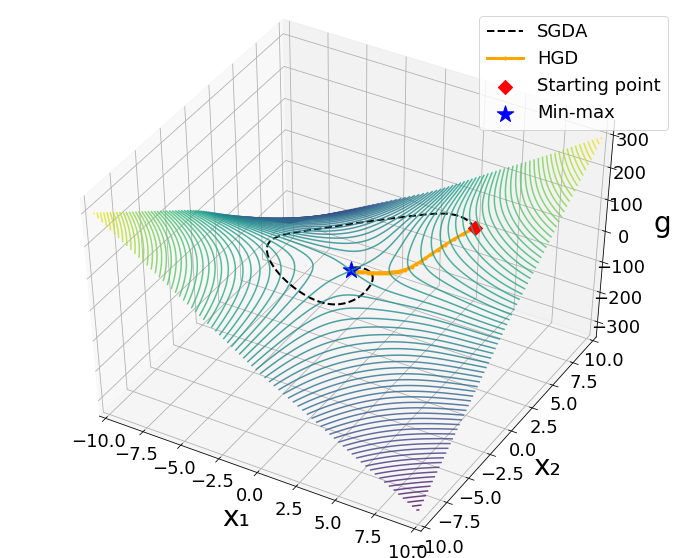

In [11]:
figure(figsize=fig_size)
ax = plt.axes(projection='3d')
ax.contour(X, Y, Z, 100, alpha=0.8)
ax.set_xlim3d(-lim, lim)
ax.set_ylim3d(-lim, lim)
ax.set_xlabel(u'x\u2081', fontsize=28, labelpad=15)
ax.set_ylabel(u'x\u2082', fontsize=28, labelpad=15)
ax.set_zlabel('g', fontsize=28, labelpad=15)
hgd_z = np.zeros(hgd_iters.shape[0])
gda_z = np.zeros(gda_iters.shape[0])
for i in range(hgd_iters.shape[0]):
    hgd_z[i] = g(np.array(hgd_iters[i,:]))
    gda_z[i] = g(np.array(gda_iters[i,:]))

w = 2 if nonconvex else 3
ax.plot(gda_iters[:,0], gda_iters[:,1], gda_z,'--', color='k', linewidth=w)
ax.plot(hgd_iters[:,0], hgd_iters[:,1], hgd_z,'.-', color='orange', linewidth=3)
ax.scatter(init_point[0], init_point[1], g(np.array(init_point)), s=100, marker='D', c='r')
ax.scatter(minmax[0], minmax[1], g(np.array(minmax)), s=300, marker='*', c='b')
ax.view_init(elev=45.)
plt.legend(["SGDA", "HGD", "Starting point", "Min-max"])
plt.savefig("HGD-GDA-contour"+save_suffix)

In [447]:
# Set contour axes limits for CO plots
lim = 10

xlist = np.linspace(-lim, lim, 100)
ylist = np.linspace(-lim, lim, 100)

X, Y = np.meshgrid(xlist, ylist)
Z = np.zeros(X.shape)

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i,j] = g(np.array([X[i,j], Y[i,j]]))

In [448]:
T = 100 if gda_converge else 15
etas = [0.1, 0.01, 0.001]
gammas = [0.1, 1, 10]
num_gammas = len(gammas)
co_iters = np.zeros((num_gammas,T+1,2))
for i in range(num_gammas):
    co_iters[i,0,:] = init_point
    for t in range(T):
        co_iters[i,t+1,:] = co(co_iters[i,t,:], etas[i], gammas[i])
    

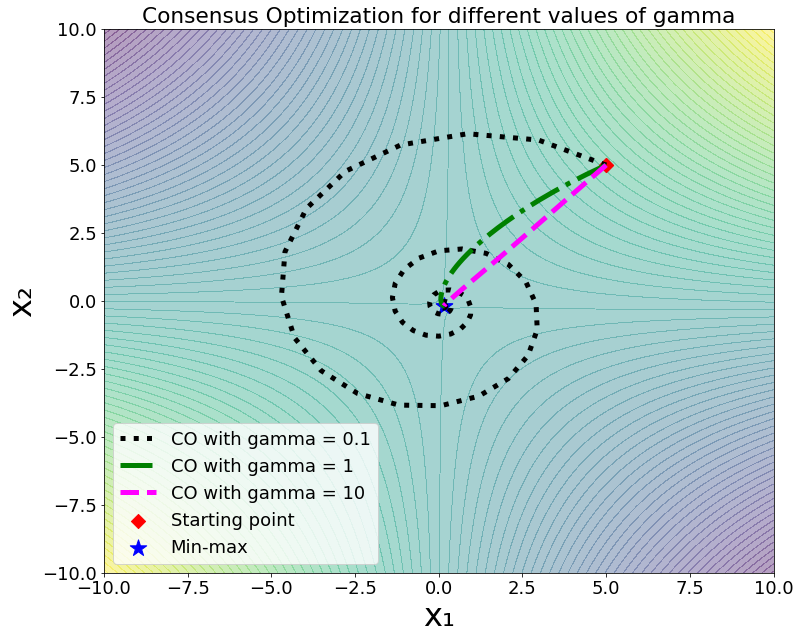

In [449]:
figure(figsize=fig_size)

linestrings = [':','-.','--']
colorstrings = ['k', 'green', 'magenta']

for i in range(num_gammas):
    plt.plot(co_iters[i,:,0], co_iters[i,:,1], linestrings[i], color=colorstrings[i], linewidth=5)

plt.scatter(init_point[0], init_point[1], s=100, marker='D', c='r')
plt.scatter(minmax[0], minmax[1], s=300, marker='*', c='b')    
plt.contourf(X, Y, Z, 100, alpha=0.4)
plt.scatter(init_point[0], init_point[1], s=100, marker='D', c='r')
plt.scatter(minmax[0], minmax[1], s=300, marker='*', c='b')    
plt.xlim(-lim,lim)
plt.ylim(-lim,lim)
    
plt.legend(["CO with gamma = 0.1", "CO with gamma = 1", "CO with gamma = 10", "Starting point", "Min-max"])
plt.title("Consensus Optimization for different values of gamma")
plt.xlabel(u'x\u2081', fontsize=32)
plt.ylabel(u'x\u2082', fontsize=32)
plt.savefig("CO"+save_suffix)

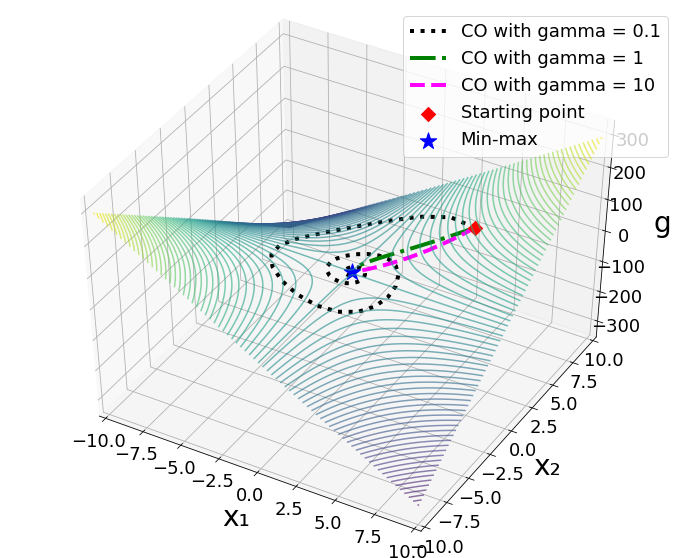

In [450]:
figure(figsize=fig_size)
ax = plt.axes(projection='3d')
ax.contour(X, Y, Z, 100, alpha=0.6)

ax.set_xlim3d(-lim, lim)
ax.set_ylim3d(-lim, lim)
ax.set_xlabel(u'x\u2081', fontsize=28, labelpad=15)
ax.set_ylabel(u'x\u2082', fontsize=28, labelpad=15)
ax.set_zlabel('g', fontsize=28, labelpad=15)
co_z = np.zeros(co_iters.shape[:2])

for i in range(num_gammas):
    for j in range(co_iters.shape[1]):
        co_z[i][j] = g(np.array(co_iters[i,j,:]))
    
linestrings = [':','-.','--']    
colorstrings = ['k', 'green', 'magenta']

for i in range(num_gammas):
    ax.plot(co_iters[i,:,0], co_iters[i,:,1], co_z[i][:], linestrings[i], color=colorstrings[i], linewidth=4)
    
ax.scatter(init_point[0], init_point[1], g(np.array(init_point)), s=100, marker='D', c='r')
ax.scatter(minmax[0], minmax[1], g(np.array(minmax)), s=300, marker='*', c='b')
ax.view_init(elev=45.)
plt.legend(["CO with gamma = 0.1", "CO with gamma = 1", "CO with gamma = 10", "Starting point", "Min-max"])
plt.savefig("CO-contour"+save_suffix)

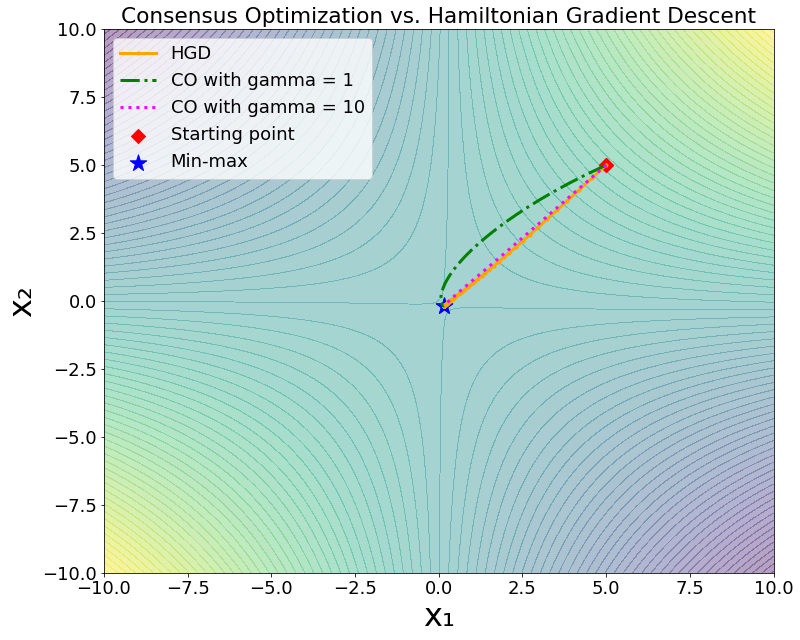

In [451]:
figure(figsize=fig_size)

plt.plot(hgd_iters[:,0], hgd_iters[:,1],'.-', color='orange', linewidth=3)

linestrings = [':','-.',':']
colorstrings = ['k', 'green', 'magenta']

for i in range(num_gammas):
    if i == 0:
        continue
    plt.plot(co_iters[i,:,0], co_iters[i,:,1], linestrings[i], linewidth=3, color=colorstrings[i])

plt.scatter(init_point[0], init_point[1], s=100, marker='D', c='r')
plt.scatter(minmax[0], minmax[1], s=300, marker='*', c='b')    
plt.contourf(X, Y, Z, 100, alpha=0.4)
plt.scatter(init_point[0], init_point[1], s=100, marker='D', c='r')
plt.scatter(minmax[0], minmax[1], s=300, marker='*', c='b')    


plt.legend(["HGD", "CO with gamma = 1", "CO with gamma = 10", "Starting point", "Min-max"])
plt.title("Consensus Optimization vs. Hamiltonian Gradient Descent")
plt.xlabel(u'x\u2081', fontsize=32)
plt.ylabel(u'x\u2082', fontsize=32)
plt.savefig("CO-HGD"+save_suffix)

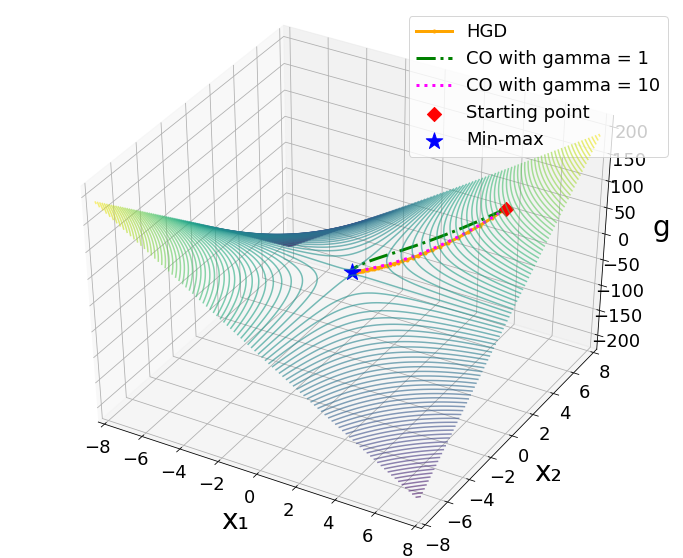

In [474]:
lim = 8

xlist = np.linspace(-lim, lim, 100)
ylist = np.linspace(-lim, lim, 100)

X, Y = np.meshgrid(xlist, ylist)
Z = np.zeros(X.shape)

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i,j] = g(np.array([X[i,j], Y[i,j]]))

figure(figsize=fig_size)
ax = plt.axes(projection='3d')
ax.contour(X, Y, Z, 100, alpha=0.6)

ax.set_xlim3d(-lim, lim)
ax.set_ylim3d(-lim, lim)
ax.set_xlabel(u'x\u2081', fontsize=28, labelpad=15)
ax.set_ylabel(u'x\u2082', fontsize=28, labelpad=15)
ax.set_zlabel('g', fontsize=28, labelpad=15)
co_z = np.zeros(co_iters.shape[:2])

for i in range(num_gammas):
    for j in range(co_iters.shape[1]):
        co_z[i][j] = g(np.array(co_iters[i,j,:]))
    
ax.plot(hgd_iters[:,0], hgd_iters[:,1], hgd_z,'.-', color='orange', linewidth=3)    
    
linestrings = [':','-.',':']    
colorstrings = ['k', 'green', 'magenta']

for i in range(num_gammas):
    if i == 0:
        continue
    ax.plot(co_iters[i,:,0], co_iters[i,:,1], co_z[i], linestrings[i], color=colorstrings[i], linewidth=3)

ax.scatter(init_point[0], init_point[1], g(np.array(init_point)), s=100, marker='D', c='r')
ax.scatter(minmax[0], minmax[1], g(np.array(minmax)), s=300, marker='*', c='b')

ax.view_init(elev=40.)
plt.legend(["HGD", "CO with gamma = 1", "CO with gamma = 10", "Starting point", "Min-max"])
plt.savefig("CO-HGD-contour"+save_suffix)

In [ ]:
# Experiments showing different convergence rate for H under different c's

In [574]:
def g(z):
    x, y = split_z(z)
    return b*x @ y  + f(x) - f(y)

In [575]:
c_range = [0, 0.5, 1, 2, 3, 5, 10]
T = 20
eta = 0.01

hgd_iters = np.zeros((len(c_range), T+1,2))

for i, c in enumerate(c_range):
    b = c
    hgd_iters[i,0,:] = init_point

    for t in range(T):
        hgd_iters[i,t+1,:] = hgd(hgd_iters[i,t,:], eta)
        

In [576]:
# get norms of points
norms = np.zeros((len(c_range), T+1))
grad_norms = np.zeros((len(c_range), T+1))
for i, c in enumerate(c_range):
    for t in range(T+1):
        norms[i, t] = np.linalg.norm(hgd_iters[i,t,:] - minmax)
        b = c
        grad_norms[i, t] = np.linalg.norm(xi(np.array(hgd_iters[i,t,:]), g))

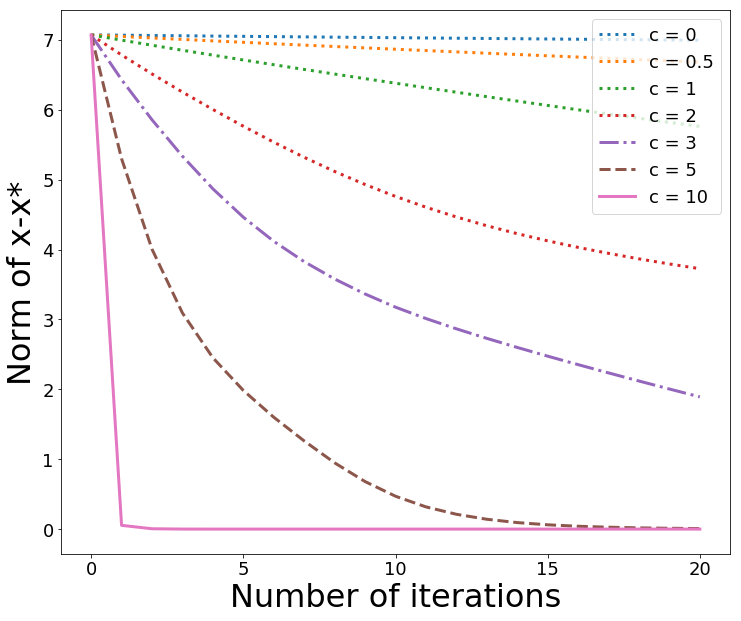

In [577]:
figure(figsize=fig_size)

linestrings = [":"]*(len(c_range)-3) + ["-.", "--", "-"]


for i in range((len(c_range))):
    plt.plot(norms[i,:], linestrings[i], linewidth=3)

plt.legend(["c = {}".format(el) for el in c_range], loc="upper right")
plt.title("")
plt.xlabel("Number of iterations", fontsize=32)
plt.xticks([0,5,10,15,20])
plt.ylabel("Norm of x-x*", fontsize=32)
plt.savefig("Norms-nonconvex.png")

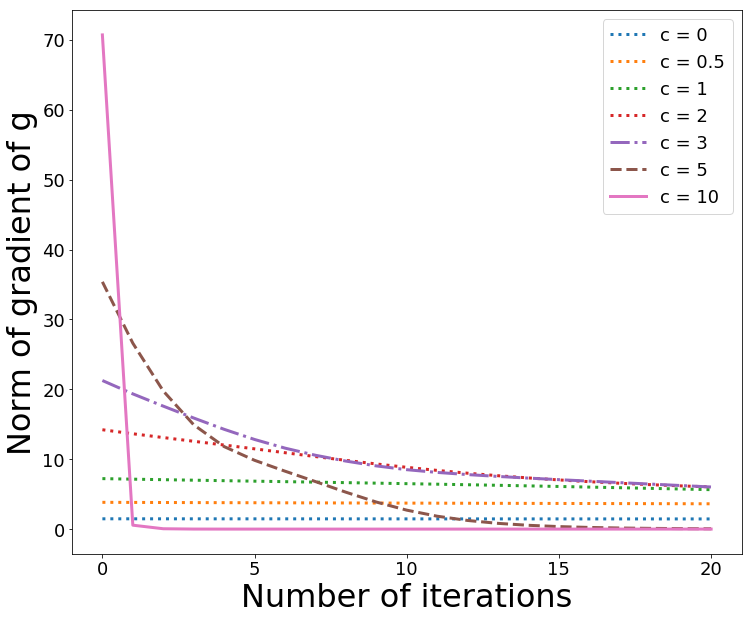

In [578]:
figure(figsize=fig_size)

linestrings = [":"]*(len(c_range)-3) + ["-.", "--", "-"]

for i in range((len(c_range))):
    plt.plot(grad_norms[i,:], linestrings[i], linewidth=3)

plt.legend(["c = {}".format(el) for el in c_range], loc="upper right")
plt.title("")
plt.xlabel("Number of iterations", fontsize=32)
plt.xticks([0,5,10,15,20])
plt.ylabel("Norm of gradient of g", fontsize=32)
plt.savefig("Grad-norms-nonconvex.png")

In [ ]:
# Plots of nonconvex objective

In [365]:
def example_g(z):
    x, y = split_z(z)
    return 4*x @ y  + nonconvex_f(x) - nonconvex_f(y)

Text(0, 0.5, 'g(•,0)')

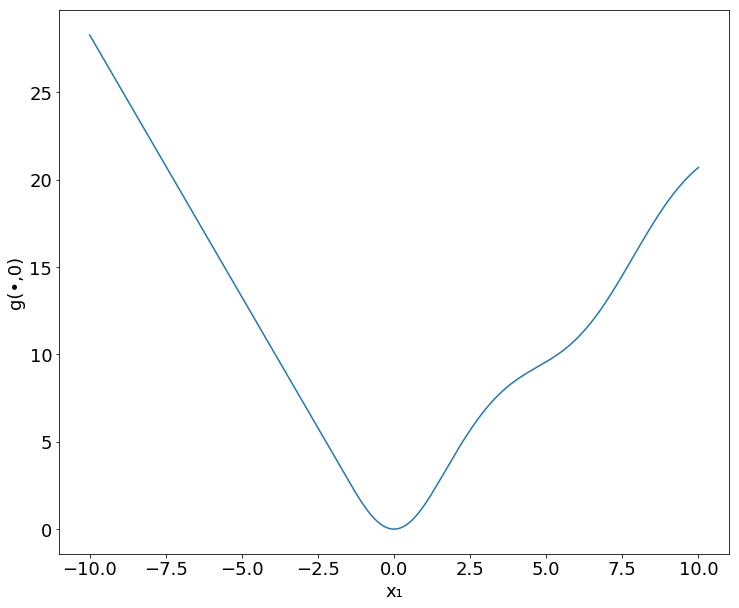

In [63]:
figure(figsize=(12, 10))
x = np.linspace(-10,10,1000)
g_x = lambda a: g(np.concatenate([a,np.zeros((1))]))
g_y = lambda a: -1*g(np.concatenate([np.zeros((1)),a]))
plt.plot(x,[g_x(np.array([b])) for b in x])
plt.xlabel(u'x\u2081')
plt.ylabel(u'g(\u2022,0)')

Text(0, 0.5, 'g(0,•)')

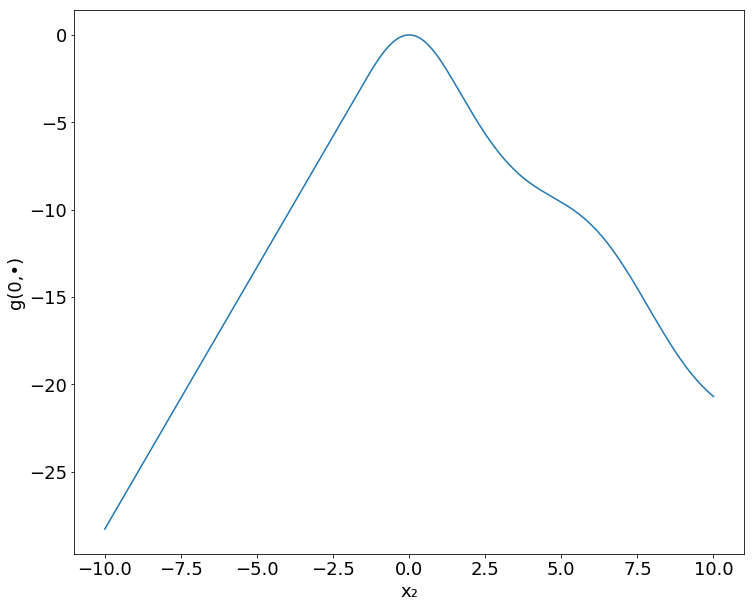

In [62]:
figure(figsize=(12, 10))
plt.plot(x,[-g_y(np.array([b])) for b in x])
plt.xlabel(u'x\u2082')
plt.ylabel(u'g(0,\u2022)')

In [458]:
lim = 8

xlist = np.linspace(-lim, lim, 300)
ylist = np.linspace(-lim, lim, 300)

X, Y = np.meshgrid(xlist, ylist)
Z = np.zeros(X.shape)

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i,j] = example_g(np.array([X[i,j], Y[i,j]]))

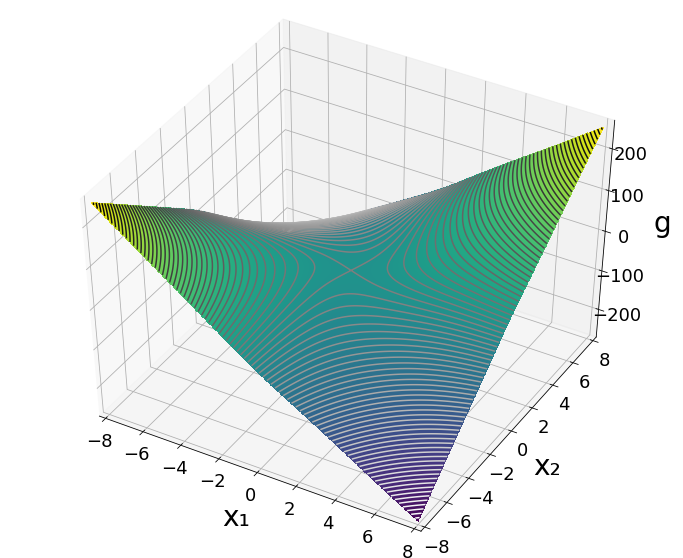

In [471]:
figure(figsize=fig_size)
ax = plt.axes(projection='3d')
ax.contourf(X, Y, Z, 300, alpha=1)
ax.contour(X, Y, Z, 100, cmap='binary')
ax.set_xlim3d(-lim, lim)
ax.set_ylim3d(-lim, lim)
ax.set_xlabel(u'x\u2081', fontsize=28, labelpad=15)
ax.set_ylabel(u'x\u2082', fontsize=28, labelpad=15)
ax.set_zlabel('g', fontsize=28, labelpad=15)

ax.view_init(elev=45.)
plt.savefig("nonconvex-nonconcave.png")